In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from smogn import smoter
import seaborn as sns
import shap

In [4]:
data = pd.read_csv('NEW TARGETS.csv')

In [6]:
# Split the data into features and target
X = data.drop(['MRT','VP','radiation','top'], axis=1)
y = data[['MRT','VP','radiation','top']]

In [ ]:
# Fit the covariance estimator to detect outliers
cov_estimator = EllipticEnvelope(contamination=0.10)  # Adjust contamination parameter as needed
cov_estimator.fit(X)

# Use the fitted estimator to predict outliers
outlier_preds = cov_estimator.predict(X)

# Remove outliers from the data
X_no_outliers = X[outlier_preds == 1]
y_no_outliers = y[outlier_preds == 1]

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

In [ ]:
# Create and train the CatBoost model
model1=mor(CatBoostRegressor()).fit(X_train, y_train)
model2=mor(RandomForestRegressor()).fit(X_train, y_train)
model3=mor(AdaBoostRegressor(n_estimators=300)).fit(X_train, y_train)
model4=mor(LGBMRegressor()).fit(X_train, y_train)
model5=mor(KNeighborsRegressor()).fit(X_train, y_train)
model6=mor(SVR()).fit(X_train, y_train)
model7=mor(LinearRegression()).fit(X_train, y_train)

In [12]:
yp1=model1.predict(X_test)
yp2=model2.predict(X_test)
yp3=model3.predict(X_test)
yp4=model4.predict(X_test)
yp5=model5.predict(X_test)
yp6=model3.predict(X_test)
yp7=model4.predict(X_test)

r1=r2_score(y_test,yp1,multioutput='raw_values')
r2=r2_score(y_test,yp2,multioutput='raw_values')
r3=r2_score(y_test,yp3,multioutput='raw_values')
r4=r2_score(y_test,yp4,multioutput='raw_values')
r5=r2_score(y_test,yp5,multioutput='raw_values')
r6=r2_score(y_test,yp6,multioutput='raw_values')
r7=r2_score(y_test,yp7,multioutput='raw_values')

In [13]:

# Initialize an empty DataFrame
columns = ['index', 'metric', 'catboost', 'random forest', 'adaboost', 'light-gbm', 'knn', 'svm', 'lr', 'max']
D = pd.DataFrame(columns=columns)

# Define helper function to calculate metrics
def calculate_metrics(y_test, y_pred):
    return {
        'R2': r2_score(y_test, y_pred, multioutput='raw_values'),
        'MSE': mean_squared_error(y_test, y_pred, multioutput='raw_values'),
        'MAE': mean_absolute_error(y_test, y_pred, multioutput='raw_values'),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')),
    }

# Predictions from all models
model_predictions = [
    model1.predict(X_test),
    model2.predict(X_test),
    model3.predict(X_test),
    model4.predict(X_test),
    model5.predict(X_test),
    model3.predict(X_test),
    model4.predict(X_test),
]

# Evaluate metrics for each model
for metric_name in ['R2', 'MSE', 'MAE', 'RMSE']:
    rows = []
    for i, column in enumerate(y_test.columns):
        metrics = []
        for yp in model_predictions:
            metrics.append(calculate_metrics(y_test, yp)[metric_name][i])
        max_metric = max(metrics)
        row = {
            'index': column,
            'metric': metric_name,
            'catboost': metrics[0],
            'random forest': metrics[1],
            'adaboost': metrics[2],
            'light-gbm': metrics[3],
            'knn': metrics[4],
            'svm': metrics[5],
            'lr': metrics[6],
            'max': max_metric,
        }
        rows.append(row)
    # Append rows to the DataFrame
    D = pd.concat([D, pd.DataFrame(rows)], ignore_index=True)

# Save results to Excel
D.to_excel('model_evaluation_metrics.xlsx', index=False)

print("Model evaluation metrics saved to 'model_evaluation_metrics.xlsx'")


In [14]:
D['index']=y_test.columns
D.to_excel('r2_models.xlsx')

In [15]:
for i in D.columns[1:8]:
    D[i]=pd.to_numeric(D[i])

<AxesSubplot:>

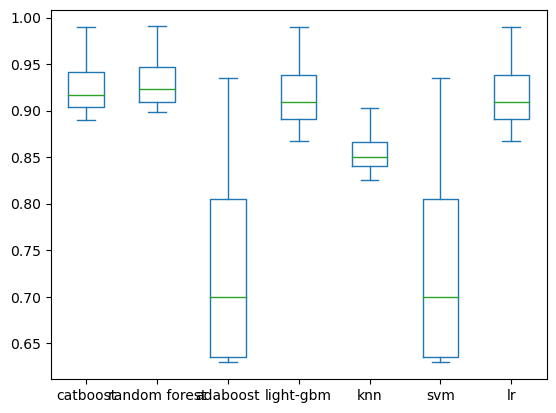

In [17]:
D.iloc[:,1:8].plot.box()

In [48]:
def plot(yp1,i):
    plt.scatter(yp1,t[3],c='b')
    plt.plot(yp1,yp1,c='r')
    plt.title(data.iloc[:,86+i:87+i].columns[0])
    plt.xlabel('y_predicted')
    plt.ylabel('y_actual')
    plt.savefig(str(i))
    plt.show()

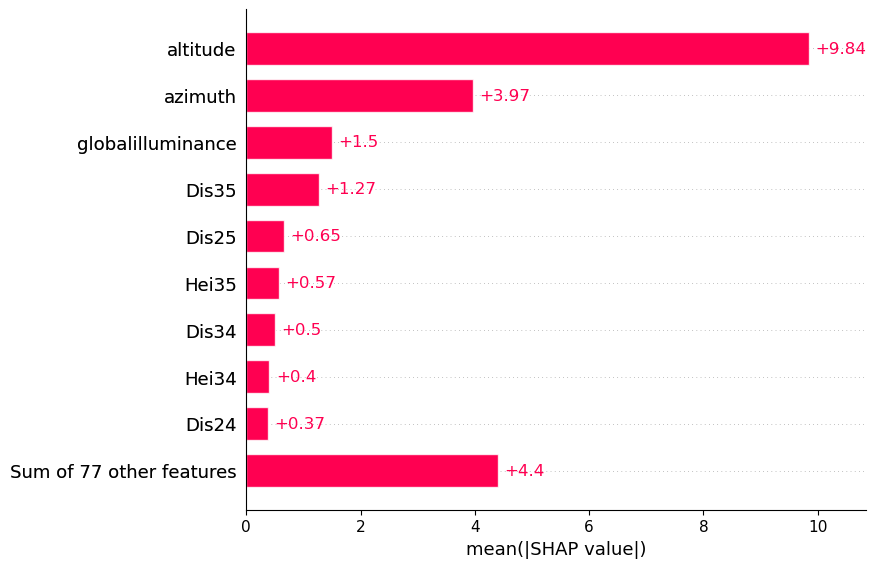

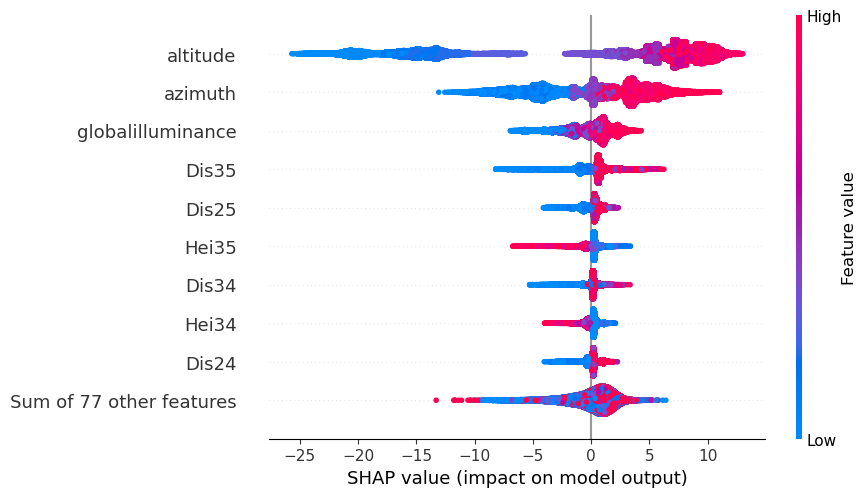

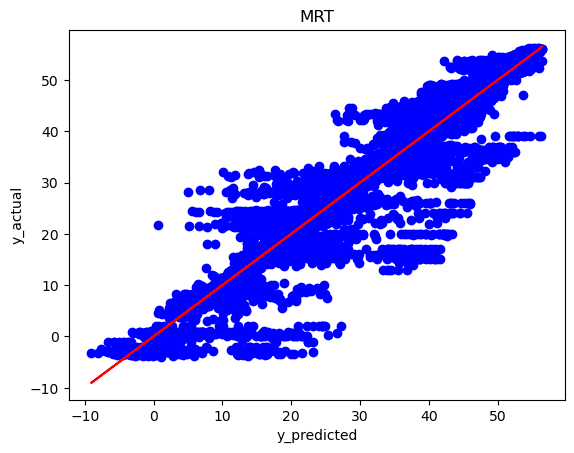

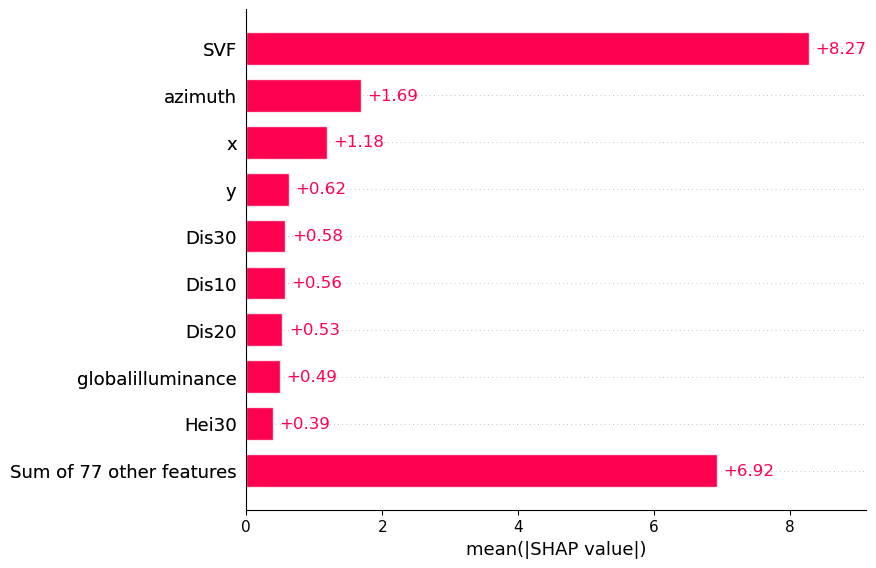

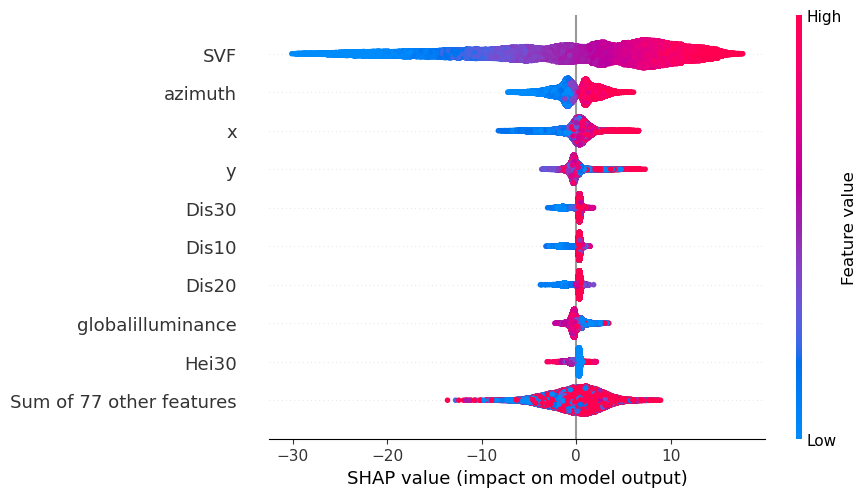

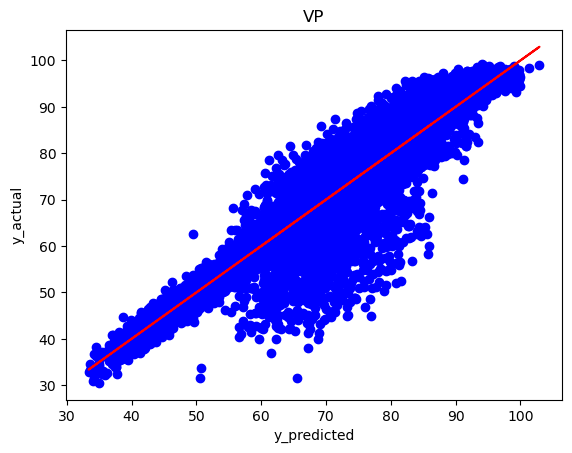

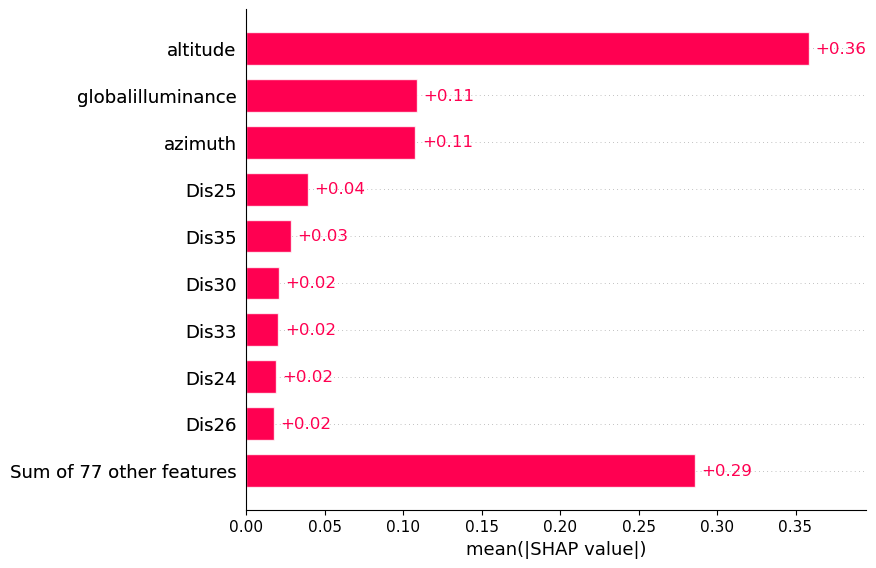

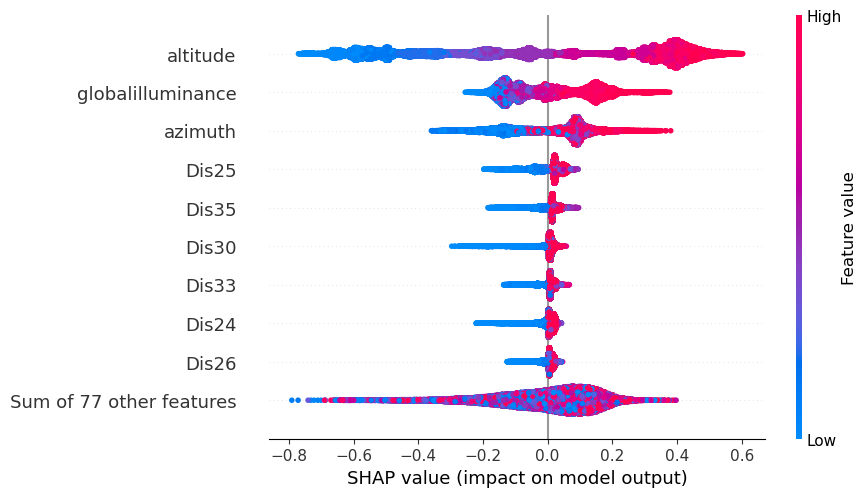

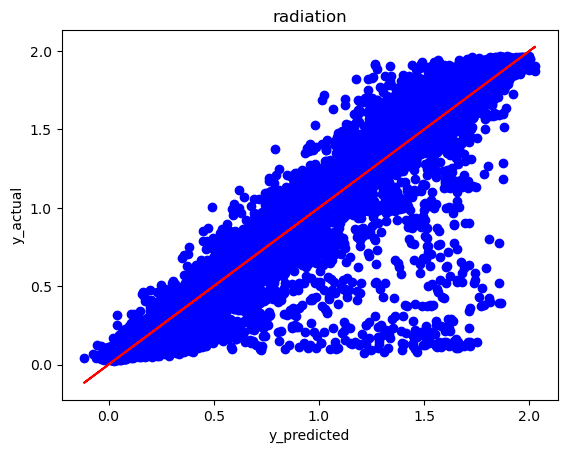

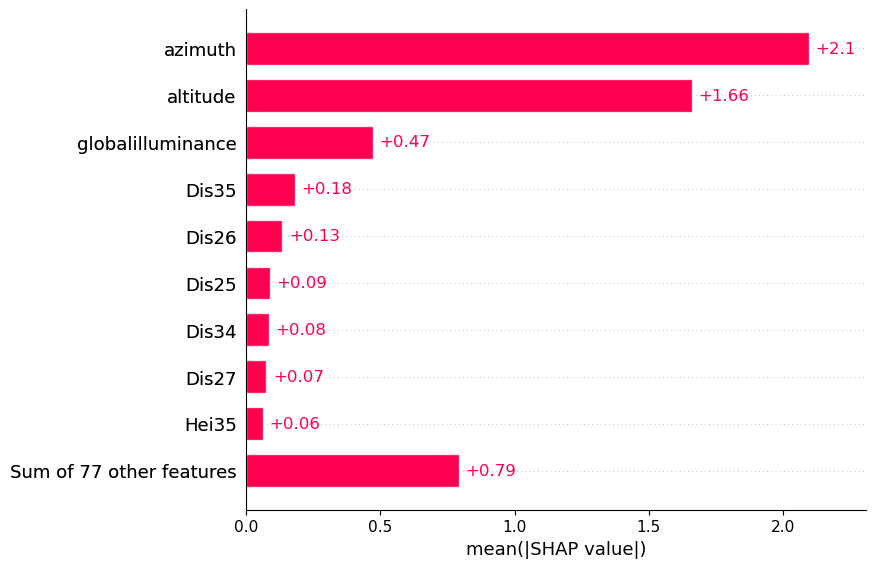

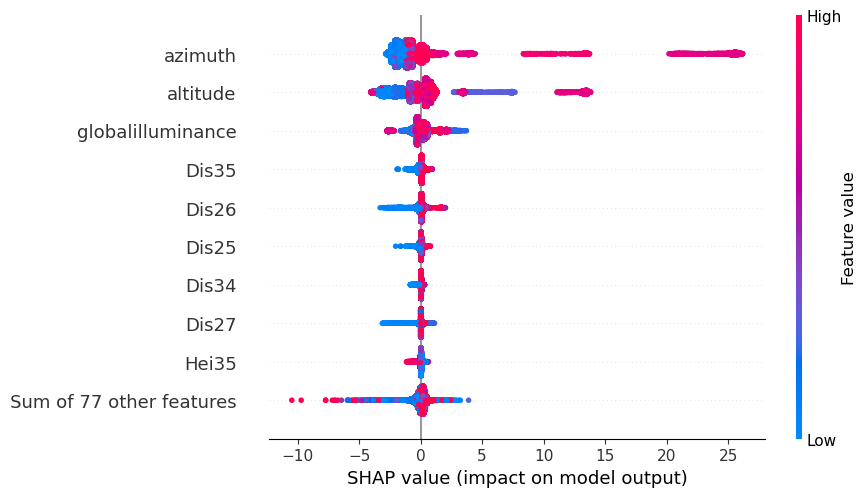

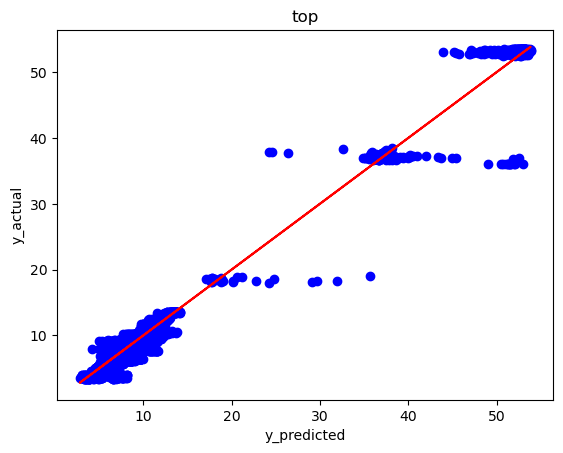

In [49]:
R2=[]
MSE=[]
MAE=[]
for i in range(0,4):    
    x=data.iloc[:,0:86]
    y=data.iloc[:,86+i:87+i]
    t=train_test_split(x,y,train_size=0.85,random_state=12)
    model1=CatBoostRegressor(verbose=False).fit(t[0],t[2])
    yp1=model1.predict(t[1])
    r2=r2_score(t[3],yp1)
    mse=mean_squared_error(t[3],yp1)
    mae=mean_absolute_error(t[3],yp1)
    R2.append(r2)
    MSE.append(mse)
    MAE.append(mae)
    explainer = shap.Explainer(model1)
    shap_values = explainer(t[0])
    #explainer = shap.TreeExplainer(model1)
    #shap_values = explainer.shap_values(t[0])
    #shap.summary_plot(shap_values,t[0])
    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)
    plot(yp1,i)
f=pd.DataFrame({'R2':R2,'MSE':MSE,'MAE':MAE})


In [50]:
f['index']=data.iloc[:,86:].columns

In [51]:
f.to_excel('metrics.xlsx')

In [7]:
from scipy.stats import spearmanr

# Calculate the Spearman correlation matrix
corr_matrix, _ = spearmanr(data)

# Display the correlation matrix
print(corr_matrix)

[[ 1.         -0.00626734  0.30367036 ...  0.07713914  0.02853456
   0.01318514]
 [-0.00626734  1.          0.00947176 ...  0.00834596 -0.08924944
  -0.04988076]
 [ 0.30367036  0.00947176  1.         ...  0.25966916  0.04700786
   0.02480185]
 ...
 [ 0.07713914  0.00834596  0.25966916 ...  1.          0.28324972
   0.19111144]
 [ 0.02853456 -0.08924944  0.04700786 ...  0.28324972  1.
   0.70490055]
 [ 0.01318514 -0.04988076  0.02480185 ...  0.19111144  0.70490055
   1.        ]]


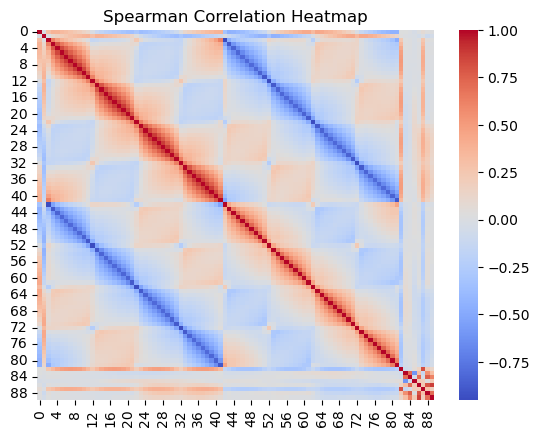

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()